In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 10
BOTTLENECK = 16
LEARNING_RATE = 0.001
DATA_PATH = '../../data/1200_processed_images_balanced.npy'
SEED = 42

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, npy_file):
        self.data = np.load(npy_file)
        self.data = self.data / 255.0 
        self.data = np.expand_dims(self.data, axis=1)
        self.data = self.data[:, :, 68:-68, 68:-68]
        print(f"Data shape: {self.data.shape}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)


class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 15 * 15, bottleneck_dim),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64 * 15 * 15),
            nn.ReLU(),
            nn.Unflatten(1, (64, 15, 15)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Pass the image through the encoder and bottleneck only."""
        with torch.inference_mode():
            encoded = self.encoder(x)
        return encoded


def display_images(original_image, encoded_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(encoded_image, cmap='gray')
    plt.title('Encoded')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
dataset = ImageDataset(DATA_PATH)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = Autoencoder(bottleneck_dim=BOTTLENECK)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    for images in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    
    val_loss = test_loss / len(test_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

torch.save(model.state_dict(), f'autoencoder_{BOTTLENECK}.pth')
print("Model saved as autoencoder.pth")

loss_data = {"train_loss": train_losses, "val_loss": val_losses}

Data shape: (1200, 1, 120, 120)
Epoch 1/10
Training Loss: 0.0460
Validation Loss: 0.0187
Epoch 2/10
Training Loss: 0.0156
Validation Loss: 0.0139
Epoch 3/10
Training Loss: 0.0127
Validation Loss: 0.0122
Epoch 4/10
Training Loss: 0.0112
Validation Loss: 0.0106
Epoch 5/10
Training Loss: 0.0096
Validation Loss: 0.0089
Epoch 6/10
Training Loss: 0.0078
Validation Loss: 0.0070
Epoch 7/10
Training Loss: 0.0058
Validation Loss: 0.0048
Epoch 8/10
Training Loss: 0.0043
Validation Loss: 0.0040
Epoch 9/10
Training Loss: 0.0037
Validation Loss: 0.0036
Epoch 10/10
Training Loss: 0.0035
Validation Loss: 0.0035
Model saved as autoencoder.pth


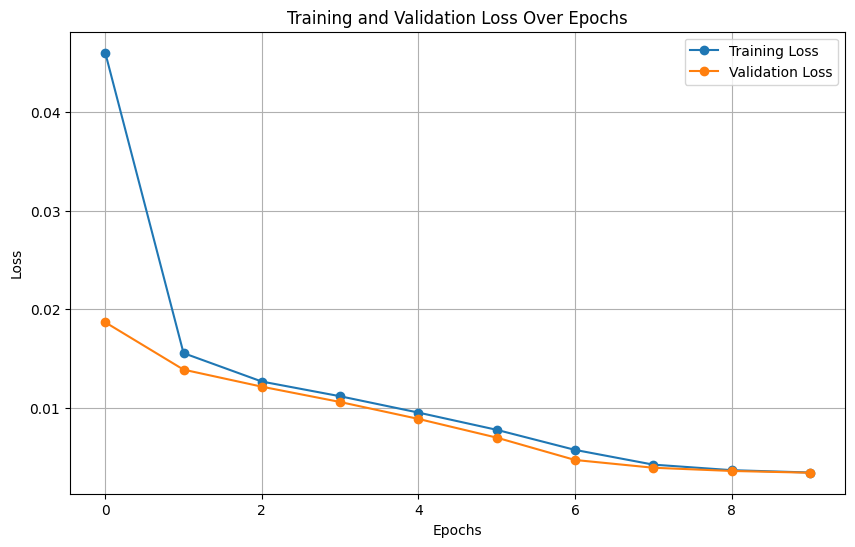

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


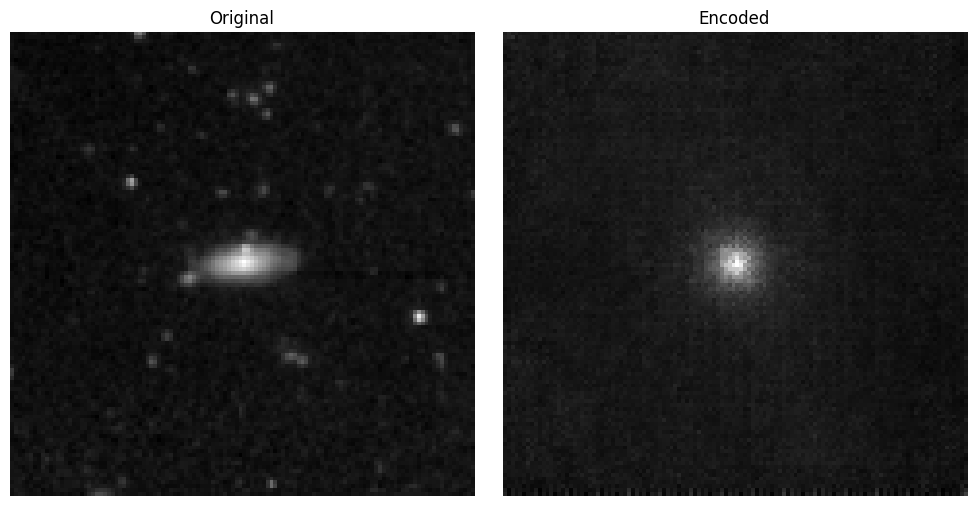

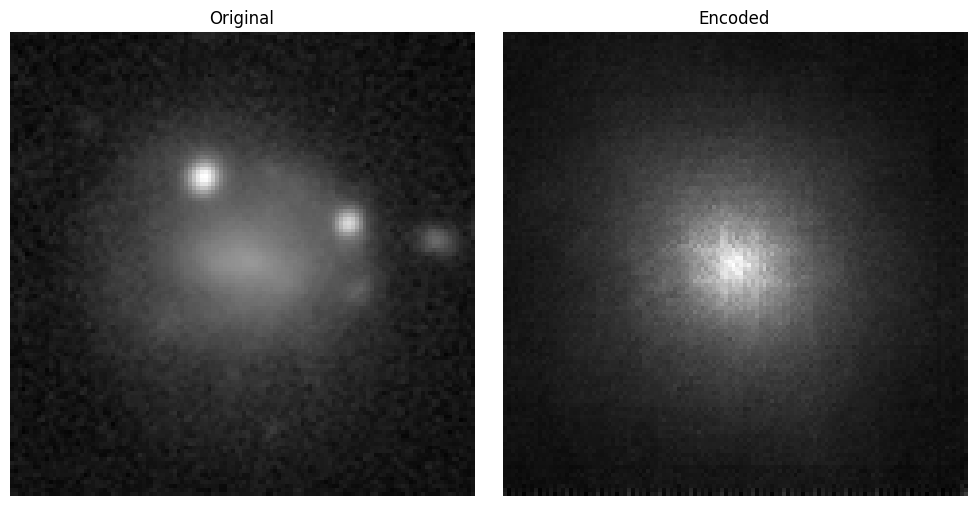

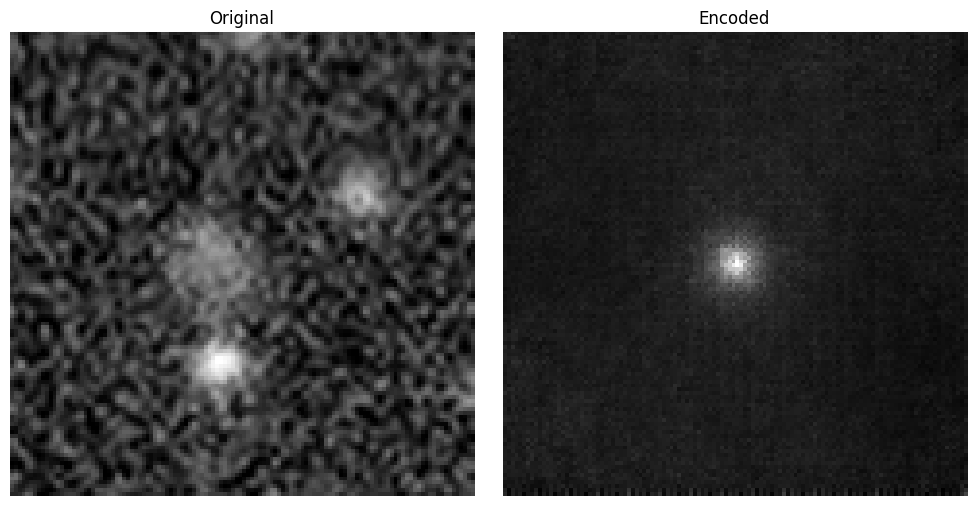

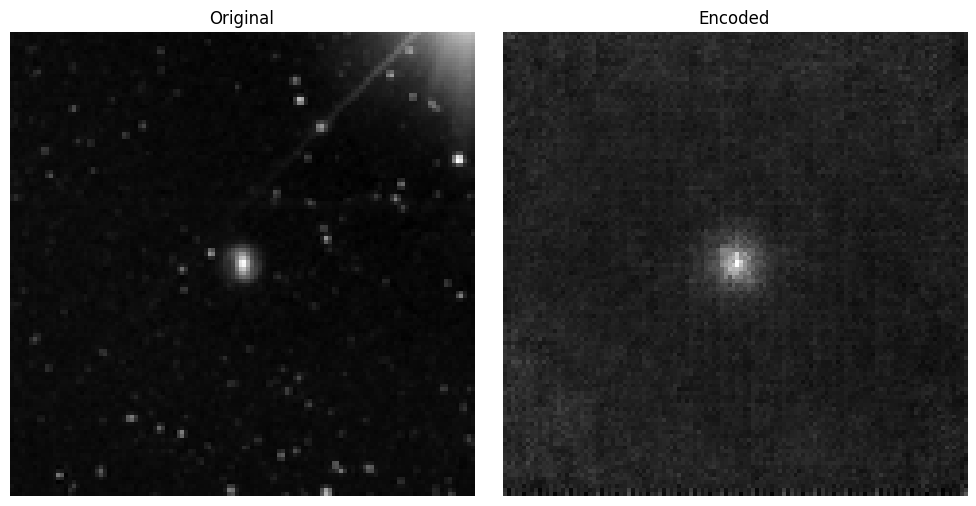

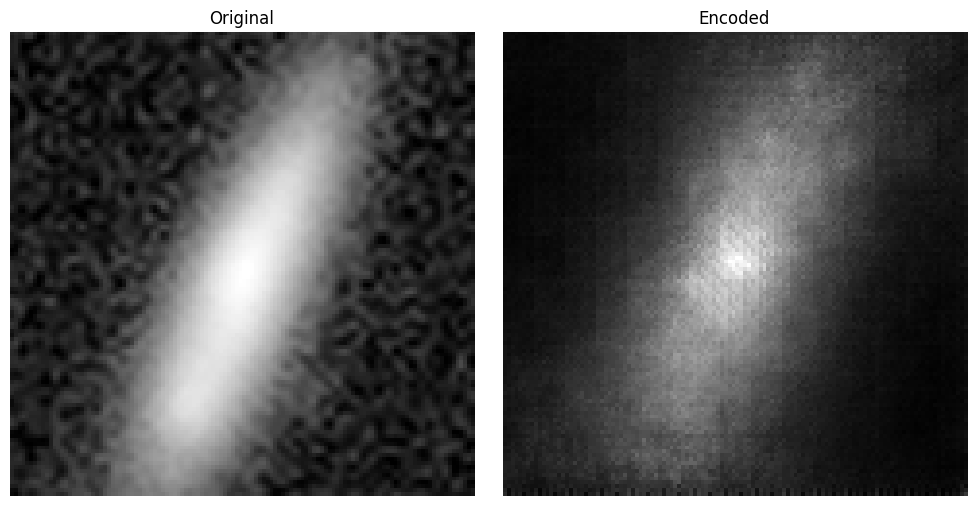

In [22]:
model.eval()

with torch.inference_mode():
    for i in range(5):
        initial = test_dataset[i]
        initial = torch.unsqueeze(initial, dim=0)
        encoded = model.encoder(initial)
        decoded = model.decoder(encoded)
        
        
        initial = np.array(initial)[0][0]
        decoded = np.array(decoded)[0][0]
        display_images(initial, decoded)

In [23]:
images = np.load(DATA_PATH)
images = images / 255.0
images = np.expand_dims(images, axis=1)
images = torch.tensor(images, dtype=torch.float32)
images = images[:, :, 68:-68, 68:-68]

images.shape, images.max()

(torch.Size([1200, 1, 120, 120]), tensor(1.))

In [24]:
model.eval()
with torch.inference_mode():
    encoded = model.encoder(images)
encoded = encoded.numpy()
encoded.shape

(1200, 16)

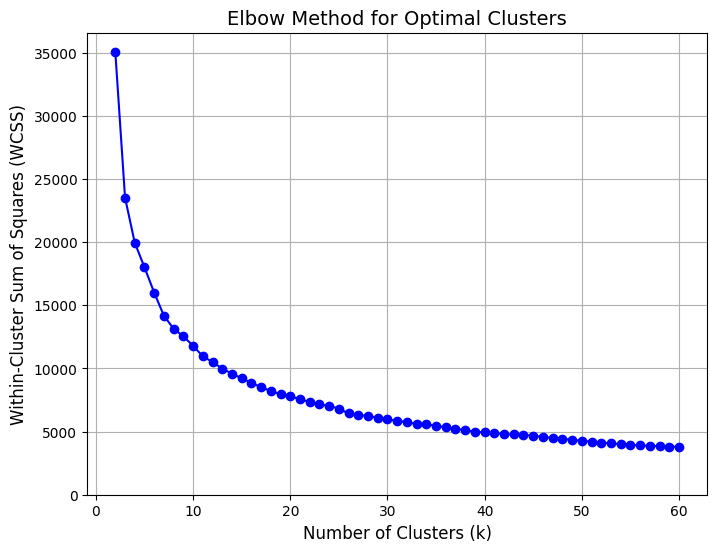

In [ ]:
max_clusters = 60
wcss = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init="auto").fit(encoded)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal Clusters", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Within-Cluster Sum of Squares (WCSS)", fontsize=12)
# plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.ylim(bottom=0)
plt.show()
